In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile,compiler, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute
from qiskit.providers.aer.noise import NoiseModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [37]:
prova = 1
n_solutions = 1
N = 4
qubits = 2
df = pd.DataFrame()



In [38]:
###########################################
#DEFINING AN EXECUTOR FUNCTION
def executor(circuit, sim, shots=10 ** 5, noise_model= None):
    """
    Executes the input circuit and returns the noisy expectation value <A>.
    Args: circuit = circuit to compute the exp value
          sim = simulator where to act
          shots = number of trials
          noise_model = noise to be used
    return: expectation value
    """
    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Run and get counts
    #print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
    job = execute(circuit_to_run, backend=sim, shots=shots, noise_model=noise_model, optimization_level=0).result()
    counts = job.get_counts()
    #print(counts)

    #plt.figure(figsize=(14,10))
    #plt.bar(counts.keys(), counts.values(), color='royalblue')
    #plt.show()
    
    # Compute expectation value of the observable
    exp_value = max(counts.values()) / shots
    return exp_value


Folding techniques

In [39]:

def circuit_folding (circuit, scaling=1):
    """
    Function that takes a circuit as a input and apply the circuit folding, considering the scaling factor
    Args: circuit = circuit to be folded
          scaling = scaling factor (1=do not fold), (3=fold one time the whole circuit)
    return: the circuit folded
    """
    #properties of the circuit
    n_qubits = circuit.width()
    qubits = list(np.arange(n_qubits))

    #retrieving from the scaling factor the number of times we need to apply the circuit
    ratio = (scaling-1)/2
    #number of times we need to fold the whole circuit
    n = int(ratio)
    #number of last layers to be folded again
    s = int((ratio-n)*circuit.size())

    circuit_folded = circuit.copy()
    c_inv = circuit_folded.inverse()
    circuit_folded.barrier()

    for i in range(0,n,1):
        circuit_folded = circuit_folded.compose(c_inv)
        circuit_folded.barrier()
        circuit_folded =circuit_folded.compose(circuit)

    #creating a partial circuit, made only of the last s layers
    if (s != 0):
        c_partial = QuantumCircuit(QuantumRegister(n_qubits))
        for j in range(circuit.size() - s, circuit.size(), 1):
            tuple = circuit.data[j][0]
            arg = circuit.data[j][1]
            args=[]
            for k in range(len(arg)):
              args.append(arg[k].index)
            c_partial.append(tuple, qargs=list(args))

        circuit_folded =circuit_folded.compose(c_partial.inverse())
        circuit_folded.barrier()
        circuit_folded =circuit_folded.compose(c_partial)

    return circuit_folded


In [40]:

def gate_folding (circuit, scaling=1, way='Left'):
    """
    Function that takes a circuit as a input and apply the gate folding, considering the scaling factor
    Args: circuit = circuit to be folded
          scaling = scaling factor (1=do not fold), (3=fold one time the whole circuit)
          way = which way to fill the circuit for s values: Left, Right, Random
    return: the circuit folded
    """
    # properties of the circuit
    n_qubits = circuit.width()
    n_gates = circuit.size()
    qubits = list(np.arange(n_qubits))

    # retrieving from the scaling factor the number of times we need to fold completely each single gate
    ratio = (scaling - 1) / 2
    # number of times we need to fold the whole circuit
    n = int(ratio)
    # number layers to be folded again one more time
    s = int((ratio - n) * n_gates)

    circuit_folded = circuit.copy()

    count = 1
    list_gates = list(np.arange(n_gates))
    random_gates = random.sample(list_gates, s)

    for i in range(n_gates):
        instruction = circuit.data[i]

        # computing the inverse and storing it into another instruction
        instruction_inverse = list(instruction)
        instruction_inverse[0] = instruction[0].inverse()
        instruction_inverse = tuple(instruction_inverse)

        for k in range(n):

            #folding the circuit for n times
            circuit_folded.data.insert(i+count, instruction_inverse)
            count+=1
            circuit_folded.data.insert(i + count, instruction)
            count += 1

        if (way=='Left'):
            if (i < s):
                circuit_folded.data.insert(i + count, instruction_inverse)
                count += 1
                circuit_folded.data.insert(i + count, instruction)
                count += 1

        if (way=='Right'):
            if (i >= (n_gates-s)):
                circuit_folded.data.insert(i + count, instruction_inverse)
                count += 1
                circuit_folded.data.insert(i + count, instruction)
                count += 1

        if (way=='Random'):
            if (i in random_gates):
                circuit_folded.data.insert(i + count, instruction_inverse)
                count += 1
                circuit_folded.data.insert(i + count, instruction)
                count += 1


    return circuit_folded

In [41]:
#DEFINING THE CIRCUIT

#defining the oracle, solutions already known
from qiskit_textbook.problems import grover_problem_oracle
oracle = grover_problem_oracle(qubits, variant=2)  # 0th variant of oracle, with n qubits


1.5707963267948966
Circuit Depth:  6
Circuit size:  10


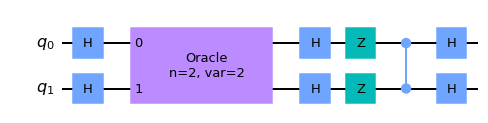

In [50]:
from qiskit.circuit.library import MCMT
from qiskit.circuit.library import ZGate

#defining the Grover gate
def grover_gate(circuit):
    # Hadamard
    for i in range(qubits):
        circuit.h(i)

    # To add a phase at all the solutions except |0>, we create a set of
    # transformations that only |0> won't trigger
    # from qiskit template
    
    
    '''
    #for 4 qubits
    for i in range(qubits):
        circuit.x(i)
    
    circuit.append(ZGate().control(3), [0,1,2,3])
        
    for i in range(qubits):
        circuit.x(i)
    '''
         
        
    '''
    #for 3 qubits
    circuit.z([0, 1, 2])

    circuit.cz(2, 1)
    circuit.cz(1, 0)
    circuit.cz(0, 2)
    #ccz = MCMT('cz', 2, 1)
    #circuit.append(ccz, [2, 1, 0])
    circuit.append(ZGate().control(2), [2,1,0])
    '''
    
    
    #for 2 qubits
    circuit.z([0,1])
    circuit.cz(0,1)
    


    #Hadamard again
    for i in range(qubits):
        circuit.h(i)
     

    #circuit.barrier()
    return circuit

#constructiong the Grover
#applying the Hadamard
circuit = QuantumCircuit(qubits)

for i in range(qubits):
    circuit.h(i)


#defining the number of times we need to apply the Grover's circuit (defined as pi/4 *sqrt(search/solutions))
print(np.pi/4 *np.sqrt(N/n_solutions))
num_times = int(np.pi/4 *np.sqrt(N/n_solutions))


for i in range(num_times):
    circuit.append(oracle, list(np.arange(qubits)))    
    grover_gate(circuit)

print('Circuit Depth: ', circuit.depth())
print('Circuit size: ', circuit.size())

circuit.draw('mpl')

In [170]:
#####################################################
#EXECUTE WITH NOISELESS BACKEND
# Set the number of shots
shots = 5*10 ** 5

# Initialize ideal backend (classical noiseless simulator)
ideal_backend = Aer.get_backend('qasm_simulator')
ideal_value = executor(circuit, ideal_backend, shots)
print('Ideal_value: ', ideal_value)

Ideal_value:  0.9454


In [171]:


###################################################
#EXECUTE WITH NOISY BACKEND
# Select a noisy backend

backend = provider.get_backend('ibmq_lima')
noise_model = NoiseModel.from_backend(backend)
simulator = Aer.get_backend('qasm_simulator')
noisy_value = executor(circuit, simulator, shots, noise_model=noise_model)
print('Noisy_value: ', noisy_value)

Noisy_value:  0.793206


CIRCUIT FOLDING
Circuit Depth:  79
Circuit circuit size:  137
148


/tmp/ipykernel_64/4009622615.py:36: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  args.append(arg[k].index)


Noisy_value:  0.57086


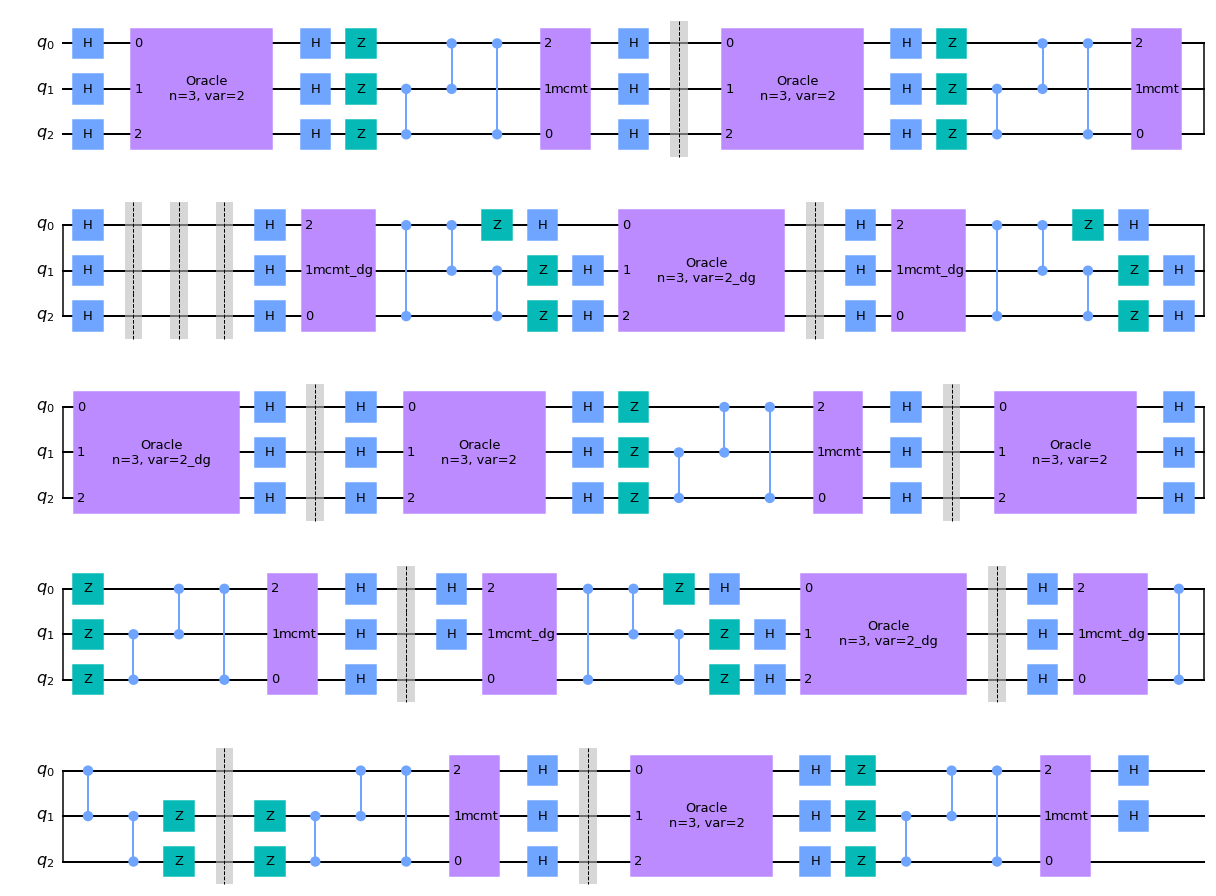

In [172]:
print('CIRCUIT FOLDING')
circuit_folded_circuit = circuit_folding(circuit, scaling = 4.5)

print('Circuit Depth: ', circuit_folded_circuit.depth())
print('Circuit circuit size: ', circuit_folded_circuit.size())
print(len(circuit_folded_circuit))

noisy_value = executor(circuit_folded_circuit, simulator, shots, noise_model=noise_model)
print('Noisy_value: ', noisy_value)

circuit_folded_circuit.draw('mpl')

Running the FOlding and computing the possible results. 

In [173]:
#definiscilo con la risoluzione che può essere data al tuo sistema in base a d
scales = np.linspace(1, 8, 15)
i = 0

for scale in scales:
    print(scale)
    circuit_folded_gate_left = gate_folding(circuit, scaling=scale, way='Left')
    value_gate_left = executor(circuit_folded_gate_left, simulator, shots=shots, noise_model=noise_model)

    circuit_folded_gate_right = gate_folding(circuit, scaling=scale, way='Right')
    value_gate_right = executor(circuit_folded_gate_right, simulator, shots=shots, noise_model=noise_model)

    circuit_folded_gate_random = gate_folding(circuit, scaling=scale, way='Random')
    value_gate_random = executor(circuit_folded_gate_random, simulator, shots=shots, noise_model=noise_model)

    circuit_folded_circuit = circuit_folding(circuit, scaling=scale)
    value_circuit = executor(circuit_folded_circuit, simulator, shots=shots, noise_model=noise_model)

    new_row = pd.Series(data={"Ideal":ideal_value,"Scale": scale, "Gate Left": value_gate_left, "Gate Right": value_gate_right,
                              "Gate Random": value_gate_random, "Circuit": value_circuit},
                        name='{}'.format(i))
    i += 1

    df = df.append(new_row, ignore_index=False)

df.to_csv('Results\Grover_3_{}.csv'.format(prova))


1.0
1.5


/tmp/ipykernel_64/4009622615.py:36: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  args.append(arg[k].index)


2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
